In [25]:
import os
from pathlib import Path
import zipfile
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import kaggle
import scraper
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

# __What makes a good midfielder?__

#### Goalkeepers guard the goal. Defenders make sure the goalkeeper is not exposed while doing so. Forwards score goals, which is the point of the game, duh. However, it can be argued that midfileders are the most integral part of a football team. They will have to stop an opponent counter attack one second, and then create one for their team the next. But what makes a good midfielder? And how do you know a midfielder is good?

#### As people who watch the game, we can usually judge how good a player is by watching them play. However, this judgement will always be subjective. How can we define an objective metric for how good a player is? We can come close, with player ratings and market values. However, since I have found no way to acquire any data for whole season player ratings, we will only work with market values. There is still a subjective element in these, however they are quite close to an objective metric and we will try to exploit them to create a hopefully even more accurate metric, as shown later on.

Let's start by getting player market values from [Transfermarkt](https://www.transfermarkt.com/), using an [auto-updated dataset from Kaggle](https://www.kaggle.com/davidcariboo/player-scores). We will filter it to only include players from the top 5 leagues.

In [26]:
players = 'players.csv'

if not os.path.isfile('data/' + players):
    # kaggle.api.authenticate()
    kaggle.api.dataset_download_cli('davidcariboo/player-scores', path='data/')

    with zipfile.ZipFile('data/player-scores.zip', 'r') as f:
        f.extract(players, 'data/')

In [27]:
players = pd.read_csv('data/' + players)
players

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,market_value_in_eur,highest_market_value_in_eur,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name
0,597,Aleksandr,Hleb,Aleksandr Hleb,2016,2696,aleksandr-hleb,UdSSR,Minsk,Belarus,...,NaN,NaN,NaN,19000000.0,NaN,fair-sport GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/aleksandr-hleb...,RU1,Krylya Sovetov Samara
1,1428,Mike,Hanke,Mike Hanke,2013,60,mike-hanke,Germany,Hamm,Germany,...,right,185.0,NaN,5000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/mike-hanke/pro...,L1,SC Freiburg
2,1560,Youssef,El Akchaoui,Youssef El Akchaoui,2012,306,youssef-el-akchaoui,Netherlands,Dordrecht,Morocco,...,NaN,NaN,NaN,1750000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/youssef-el-akc...,NL1,SC Heerenveen
3,1587,Mario,Eggimann,Mario Eggimann,2012,42,mario-eggimann,Switzerland,Brugg,Switzerland,...,right,190.0,NaN,3000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/mario-eggimann...,L1,Hannover 96
4,1726,Heiko,Westermann,Heiko Westermann,2016,610,heiko-westermann,Germany,Alzenau,Germany,...,right,190.0,NaN,9000000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/heiko-westerma...,NL1,Ajax Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28471,199337,Rifat,Erdem,Rifat Erdem,2013,2293,rifat-erdem,Turkey,Konya,Turkey,...,right,NaN,NaN,100000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/rifat-erdem/pr...,TR1,Konyaspor
28472,209569,Mücahit,Atalay,Mücahit Atalay,2020,2293,mucahit-atalay,Turkey,Trabzon,Turkey,...,right,186.0,NaN,250000.0,2023-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/mucahit-atalay...,TR1,Konyaspor
28473,221118,Patrick Friday,Eze,Patrick Friday Eze,2017,2293,patrick-friday-eze,Nigeria,Kaduna,Nigeria,...,right,187.0,200000.0,775000.0,2023-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/patrick-friday...,TR1,Konyaspor
28474,273053,Burak,Saban,Burak Saban,2018,2293,burak-saban,Netherlands,Hoorn,Netherlands,...,both,177.0,NaN,200000.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/burak-saban/pr...,TR1,Konyaspor


Discarding of data that are not relevant to our analysis:

In [28]:
# only keep active players
players = players[players.last_season == 2022]

# only keep players from the top 5 leagues
top5 = ['GB1', 'L1', 'ES1', 'IT1', 'FR1']
players = players[players.current_club_domestic_competition_id.isin(top5)]
players.dropna(subset=['market_value_in_eur'], inplace=True)

players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
today = pd.to_datetime('today')
players['age'] = (today - players['date_of_birth']).dt.days / 365
players['age'] = players['age'].round()

players = players[['name', 'market_value_in_eur', 'age']]
players.columns = ['Name', 'Value', 'Age']
players = players.astype({'Value': int, 'Age': int})

players.sort_values('Value', ascending=False, inplace=True)
players.reset_index(inplace=True, drop=True)

players

,Name,Value,Age
0,Kylian Mbappé,180000000,25
1,Erling Haaland,170000000,23
2,Vinicius Junior,120000000,23
3,Jude Bellingham,120000000,20
4,Jamal Musiala,110000000,20
...,...,...,...
2635,Davide Marfella,50000,24
2636,Simon Walde,50000,19
2637,Javi Guerra,50000,20
2638,Matteo Fiorenza,25000,20


It will be interesting to first explore how age affects market value, since it is a common perception that a player's value will increase with age, until a point when they reach their peak, and then it will start to decrease. <br>
First, let's visualize the relationship between age and market value with a scatter plot.

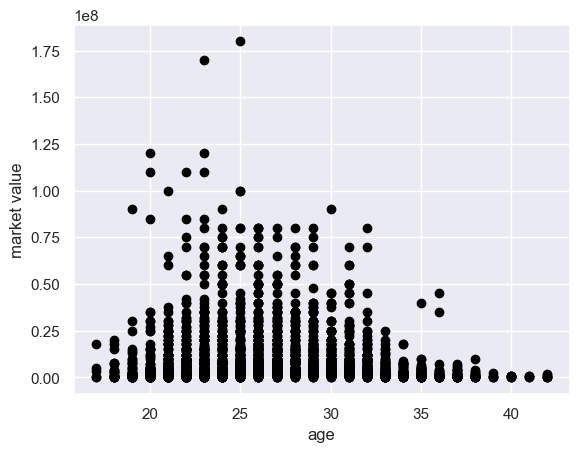

In [29]:
X = players[['Age']]
y = players['Value']

plt.scatter(X, y, color='black')
plt.xlabel('age')
plt.ylabel('market value')
plt.show()

The scatter plot confirms our intuition about the relationship between age and market value, however we can see that the variance is not similar throughout all ages, so the data does not meet the homoscedasticity assumption for linear regression. <br>
We can still try to fit a linear regression model to the data, and see how it does. Since we don't expect the relationship to be linear, we will create polynomial features so this will be in fact a polynomial regression.

In [30]:
def plot_model(model):
    x = np.arange(X.values.min(), X.values.max() + 1).reshape(-1, 1)

    plt.scatter(X, y, color='black')
    plt.plot(x, model.predict(x), color='red', linewidth=3)
    plt.xlabel('age')
    plt.ylabel('market value')
    plt.show()

R-squared: 0.05718
RMSE: 15,245,701 €


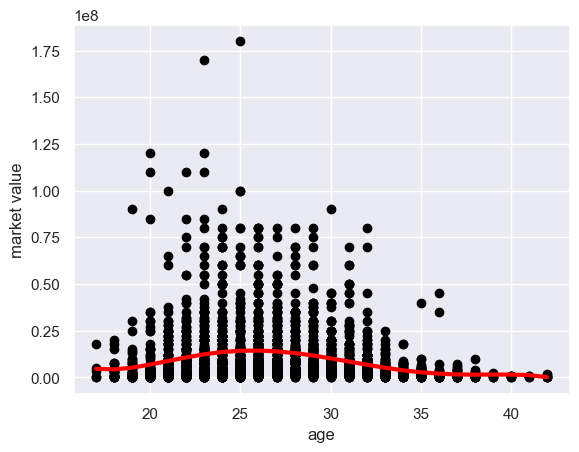

In [31]:
model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X, y)

y_pred = model.predict(X)
r2 = metrics.r2_score(y, y_pred)
rmse = metrics.mean_squared_error(y, y_pred, squared=False)

print(f'R-squared: {r2:.5f}')
print(f'RMSE: {rmse:,.0f} €')
plot_model(model)

Polynomial features of degree 2 seemed to not be good enough, and after a bit of trial and error, 5 seems to be the sweetspot, however the difference from 3 to 5 is not that big. <br>
The model seems to capture the relationship we have observed, however the R-squared is very low, and the root mean squared error is quite high. <br>
Of course, R-squared is not the perfect metric for non-linear relationships, but the lack of homoscedasticity must have also played a role in the low score of the model.

Let's now get player stats from FBRef.com using [a scraper I made](https://github.com/NikosKont/FBref-Scraper), and see if we can find a better model for predicting market value.

In [32]:
stats = 'stats.csv'

if os.path.isfile('data/' + stats):
    stats = pd.read_csv('data/' + stats)
else:
    stats = scraper.get_player_stats('standard', 'Big5')
    cols = stats.columns.to_numpy()
    cols[26:] += '/90'
    stats.columns = cols
    stats.drop(['Nation', 'Squad', 'Comp', 'Age', 'Born'], axis=1, inplace=True)
    stats.to_csv('data/' + stats, index=False)

stats

,Player,Pos,MP,Starts,Min,90s,Gls,Ast,G+A,G-PK,...,Gls/90,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90
0,Brenden Aaronson,"MF,FW",36,28,2372,26.4,1,3,4,1,...,0.04,0.11,0.15,0.04,0.15,0.15,0.16,0.31,0.15,0.31
1,Paxten Aaronson,"MF,DF",7,0,173,1.9,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.09,0.03,0.11,0.09,0.11
2,James Abankwah,DF,1,0,5,0.1,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,George Abbott,MF,1,0,1,0.0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,Yunis Abdelhamid,DF,36,36,3240,36.0,1,2,3,1,...,0.03,0.06,0.08,0.03,0.08,0.06,0.03,0.09,0.06,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,Szymon Żurkowski,MF,2,0,32,0.4,0,1,1,0,...,0.00,2.81,2.81,0.00,2.81,0.33,0.06,0.40,0.33,0.40
2861,Szymon Żurkowski,MF,9,2,340,3.8,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.04,0.04,0.04
2862,Martin Ødegaard,MF,37,37,3127,34.7,15,7,22,15,...,0.43,0.20,0.63,0.43,0.63,0.29,0.23,0.52,0.29,0.52
2863,Milan Đurić,FW,27,13,1308,14.5,1,1,2,1,...,0.07,0.07,0.14,0.07,0.14,0.10,0.09,0.19,0.10,0.19


Because the names of the players are not exactly the same in both datasets, we will have to do some extra work to match them. <br>
We will allow a maximum of 2 characters difference between the names, and will match those that meet this criterion.

In [33]:
def match(s1, s2):
    if s1 == s2:
        return True
    if len(s1) != len(s2):
        return False
    
    diff = 0

    for c1, c2 in zip(s1, s2):
        if c1 != c2:
            diff += 1
        if diff > 2:
            return False

    return True

diff1 = np.setdiff1d(players.Name, stats.Player)
diff2 = np.setdiff1d(stats.Player, players.Name)

# find matches between the two arrays that have a maximum of one character difference
matches = []
for name1 in diff1:
    for name2 in diff2:
        if match(name1, name2):
            matches.append((name1, name2))

for name1, name2 in matches:
    stats.loc[stats.Player == name2, 'Player'] = name1

Combining the two datasets:

In [34]:
players = pd.merge(players, stats, left_on='Name', right_on='Player')
players.drop(['Player'], axis=1, inplace=True)
players = players[players['Pos'].str.find('MF') != -1]
players.dropna(inplace=True)
players

,Name,Value,Age,Pos,MP,Starts,Min,90s,Gls,Ast,...,Gls/90,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90
3,Jude Bellingham,120000000,20,MF,31,30,2691,29.9,8,4,...,0.27,0.13,0.40,0.23,0.37,0.27,0.14,0.41,0.25,0.38
4,Jamal Musiala,110000000,20,"MF,FW",33,26,2198,24.4,12,10,...,0.49,0.41,0.90,0.49,0.90,0.33,0.27,0.60,0.33,0.60
8,Pedri,100000000,21,MF,26,22,1976,22.0,6,1,...,0.27,0.05,0.32,0.27,0.32,0.22,0.23,0.45,0.22,0.45
9,Federico Valverde,100000000,25,"MF,FW",34,29,2502,27.8,7,4,...,0.25,0.14,0.40,0.25,0.40,0.15,0.23,0.38,0.15,0.38
10,Aurélien Tchouaméni,90000000,24,MF,32,24,2086,23.2,0,4,...,0.00,0.17,0.17,0.00,0.17,0.08,0.10,0.17,0.08,0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,Christian Acella,150000,21,MF,1,0,15,0.2,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2351,Jean-Mattéo Bahoya,100000,18,"FW,MF",10,2,270,3.0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.17,0.12,0.29,0.17,0.29
2352,Yanis Massolin,100000,21,MF,6,0,60,0.7,0,0,...,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.07,0.07,0.07
2353,Kévin Danois,100000,19,MF,1,0,2,0.0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


It will be interesting to see the results, by repeating the same process as before, but this time using only players with at least 270 minutes played this season. This is a bare minimum that will ensure that the player is invovled at least to some extent, so for example academy players who are just there to fill the squad or players with long-term injuries will be excluded and not affect the results. This will also be useful later, since less involvement than that is a small sample size for a player's stats.

R-squared: 0.05711
RMSE: 16,499,887 €


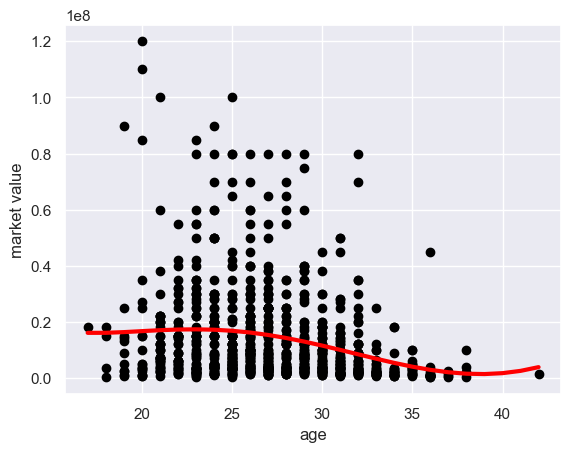

In [35]:
players = players[players.Min >= 270]

X = players[['Age']]
y = players['Value']

model = make_pipeline(PolynomialFeatures(5), LinearRegression())
model.fit(X, y)

y_pred = model.predict(X)
r2 = metrics.r2_score(y, y_pred)
rmse = metrics.mean_squared_error(y, y_pred, squared=False)

print(f'R-squared: {r2:.5f}')
print(f'RMSE: {rmse:,.0f} €')
plot_model(model)

We can see that the R-squared has indeed increased, but so has the RMSE. We will keep this model since it also contains a more appropriate sample of players. <br>
Based on this result, we will correct the market value for age and use this normalised market value as our metric of a player's quality for the upcoming analysis.

In [39]:
x = np.arange(X.values.min(), X.values.max() + 1)
pred_value_per_age = {age: model.predict(np.array([age]).reshape(-1, 1))[0] for age in x}

Norm_Value = players['Value'] / y_pred
players.insert(2, 'Norm_Value', Norm_Value)
players.sort_values('Norm_Value', ascending=False, inplace=True)
players.reset_index(inplace=True, drop=True)
players.head(15)

,Name,Value,Norm_Value,Age,Pos,MP,Starts,Min,90s,Gls,...,Gls/90,Ast/90,G+A/90,G-PK/90,G+A-PK/90,xG/90,xAG/90,xG+xAG/90,npxG/90,npxG+xAG/90
0,Lionel Messi,45000000,16.015508,36,"FW,MF",31,31,2747,30.5,16,...,0.52,0.52,1.05,0.52,1.05,0.49,0.43,0.91,0.49,0.91
1,Kevin De Bruyne,80000000,9.579451,32,MF,32,28,2417,26.9,7,...,0.26,0.60,0.86,0.26,0.86,0.21,0.51,0.72,0.21,0.72
2,Neymar,70000000,8.382020,32,"MF,FW",20,18,1545,17.2,13,...,0.76,0.64,1.40,0.64,1.28,0.47,0.51,0.98,0.38,0.89
3,Jude Bellingham,120000000,7.218116,20,MF,31,30,2691,29.9,8,...,0.27,0.13,0.40,0.23,0.37,0.27,0.14,0.41,0.25,0.38
4,Luka Modric,10000000,6.978790,38,MF,32,19,1727,19.2,4,...,0.21,0.16,0.36,0.16,0.31,0.22,0.24,0.46,0.18,0.42
5,Jamal Musiala,110000000,6.616607,20,"MF,FW",33,26,2198,24.4,12,...,0.49,0.41,0.90,0.49,0.90,0.33,0.27,0.60,0.33,0.60
6,Bernardo Silva,80000000,6.199747,29,"MF,FW",34,24,2205,24.5,4,...,0.16,0.20,0.37,0.16,0.37,0.09,0.13,0.22,0.09,0.22
7,Federico Valverde,100000000,5.967358,25,"MF,FW",34,29,2502,27.8,7,...,0.25,0.14,0.40,0.25,0.40,0.15,0.23,0.38,0.15,0.38
8,Pedri,100000000,5.895888,21,MF,26,22,1976,22.0,6,...,0.27,0.05,0.32,0.27,0.32,0.22,0.23,0.45,0.22,0.45
9,Bruno Fernandes,75000000,5.812262,29,"MF,FW",37,37,3316,36.8,8,...,0.22,0.22,0.43,0.16,0.38,0.25,0.45,0.71,0.21,0.66


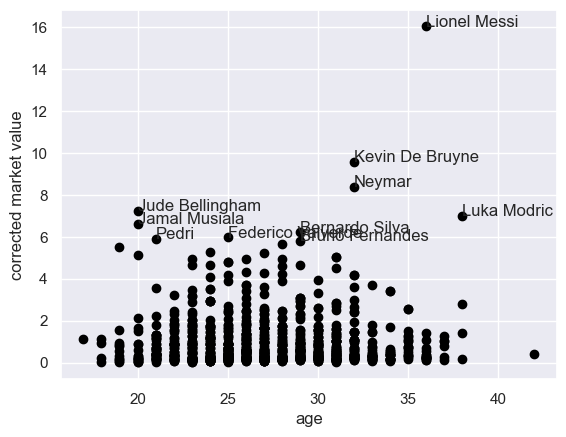

In [40]:
X = players['Age']
y = players['Norm_Value']

plt.scatter(X, y, color='black');
for i, txt in enumerate(players.sort_values('Norm_Value', ascending=False).iloc[:10].Name):
    plt.annotate(txt, (X.iloc[i], y.iloc[i]))

plt.xlabel('age')
plt.ylabel('corrected market value')
plt.show()

We can see that this definitely is a good metric for a player's quality, judging by the players that are at the top of the list. <br>
Let's now use all the available stats, and determine which of those are most important. <br>
Using statsmodels, we can define a multiple linear regression model, and get a more detailed summary that will prove useful. <br>
We should note however that the model is not perfect, since most stats are not independent of each other, and thus collinearity is present.

In [41]:
X = players.iloc[:, 17:]
y = players['Norm_Value']

model = sm.OLS(y, X).fit()
r2 = model.rsquared_adj

# while the adjusted R-squared is not decreasing, remove the feature with the highest p-value
while True:
    max_pvalue_idx = model.pvalues.idxmax()
    max_pvalue = model.pvalues[max_pvalue_idx]
    X = X.drop(columns=max_pvalue_idx)

    model = sm.OLS(y, X).fit()

    if model.rsquared_adj < r2:
        break
    r2 = model.rsquared_adj

selected_features = X.columns
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             Norm_Value   R-squared (uncentered):                   0.612
Model:                            OLS   Adj. R-squared (uncentered):              0.606
Method:                 Least Squares   F-statistic:                              107.9
Date:                Mon, 31 Jul 2023   Prob (F-statistic):                   1.31e-172
Time:                        15:27:42   Log-Likelihood:                         -1293.9
No. Observations:                 903   AIC:                                      2614.
Df Residuals:                     890   BIC:                                      2676.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

Let's check which are the significant stats for predicting player quality (with significance level 0.05):

In [15]:
rej, p_corr, _, _ = sm.stats.multipletests(model.pvalues, alpha=0.05, method='fdr_bh')
res = pd.DataFrame({'feature': X.columns, 'p-value': model.pvalues, 'p_corrected': p_corr, 'coef': model.params, 'rejected': rej}).sort_values('p_corrected').reset_index(drop=True)
res

,feature,p-value,p_corrected,coef,rejected
0,PrgP,2.019192e-14,2.624950e-13,0.005335,True
1,PrgR,8.954937e-06,5.820709e-05,-0.005873,True
2,npxG+xAG,2.274588e-03,9.856546e-03,0.401106,True
3,PrgC,1.884791e-02,6.125569e-02,0.006011,False
4,xAG,4.345544e-02,1.129841e-01,-0.284527,False
5,xG,5.622372e-02,1.218181e-01,-0.230477,False
6,xG+xAG/90,8.172700e-02,1.480497e-01,29.639933,False
7,npxG+xAG/90,9.110750e-02,1.480497e-01,-28.738477,False
8,xG/90,1.389598e-01,1.981169e-01,-24.582137,False
9,npxG/90,1.523976e-01,1.981169e-01,23.766716,False


We can see that **PrgP (Progressive Passes)** is the most important stat. This makes sense, since progressive passes are essential to the build-up of an attack, however they are not easy to pull off because they will usually need to break opponents' lines and be executed within tight spaces, so players who can make these kind of passes consistently are very valuable. <br>
The other statistically significant stats are **PrgR (Progressive Receptions)** and **npxG+xAG (non-penalty xGoals + xAssistedGoals)**. npxG+xAG has a quite high coefficient, especially compared to PrgP, it is unexpected however that PrgR has a negative coefficient. This is likely to be due to the existence of collinearity. <br>
Using VIF, we can check how much of a problem collinearity is for our model:

In [220]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,feature,VIF
0,xG,32.337952
1,npxG,4218.557530
2,xAG,3696.624749
3,npxG+xAG,14388.475445
4,PrgC,10.058941
5,PrgP,3.612024
6,PrgR,12.946066
7,Gls/90,2891.433578
8,Ast/90,1835.265927
9,G+A/90,7533.043284


Turns out that most stats have (extremely) high VIF, which means that they are highly correlated with other stats. <br>
As a last step, let's try to create a model that eliminates collinearity as much as possible, by using only a handful of stats that could be most important based on the previous results. <br>
We'll use PrgP and PrgR, as well as npxG+xAG/90. The first two were the 2 of the 3 statistically significant stats in the previous model, while npxG+xAG/90 did not appear to be statistically significant, however this was likely due to issues with collinearity. It is obviously quite similar, but in my opinion more accurate than the 3rd statistically significant stat from before, npxG+xAG. <br>

In [221]:
features = ['PrgP', 'PrgR', 'npxG+xAG/90']
X = players[features]

model = sm.OLS(y, X).fit()
r2 = model.rsquared_adj

selected_features = X.columns
print('Selected Features:', selected_features.values)
print(model.summary())

Selected Features: ['PrgP' 'PrgR' 'npxG+xAG/90']
                                 OLS Regression Results                                
Dep. Variable:             Norm_Value   R-squared (uncentered):                   0.481
Model:                            OLS   Adj. R-squared (uncentered):              0.479
Method:                 Least Squares   F-statistic:                              277.8
Date:                Sun, 18 Jun 2023   Prob (F-statistic):                   1.37e-127
Time:                        02:52:06   Log-Likelihood:                         -1545.5
No. Observations:                 903   AIC:                                      3097.
Df Residuals:                     900   BIC:                                      3111.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025    

The coefficient for PrgR is now positive as expected, however it seems it is not nearly significant enough. <br>
It is clear however that PrgP and npxG+xAG/90 are (very) significant (p-value < 0.001), with npxG+xAG/90 also having a quite higher coefficient as well. <br>
We can see the adjusted R-squared has decreased, however we can now confirm there are no collinearity issues since all VIFs are below 5:

In [222]:
vif = pd.DataFrame()
vif['feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,feature,VIF
0,PrgP,2.047578
1,PrgR,3.923800
2,npxG+xAG/90,3.632507
